# Action1基于能力描述的薪资预测

数据集：抓取了4512个职位的能力描述，薪资     
Step1，数据加载     
Step2，可视化，使用Networkx     
Step3，提取文本特征 TFIDF     
Step4，回归分析，使用KNN回归，朴素贝叶斯回归，训练能力和薪资匹配模型     
Step5，基于指定的能力关键词，预测薪资

1、完成代码（30points）     2、结果正确（20points）

## Step1，数据加载

In [128]:
# 数据加载
import pandas as pd
# pd.set_option('display.max_rows',2)
file = 'jobs_4k.xls'
content = pd.read_excel(file)
content.head(1)

,id,positionName,district,stationname,jobNature,companyLabelList,industryField,salary,companySize,skillLables,createTime,companyFullName,workYear,education,positionAdvantage,url,detail,type
0,3,财务产品经理,海淀区,上地,全职,"['节日礼物', '年底双薪', '定期体检', '七险一金']","物流丨运输,软件开发",10k-15k,500-2000人,"['产品设计', '后台', 'B2B']",2020-05-15 15:10:02,北京福佑多多信息技术有限公司,1-3年,本科,福利待遇好、创业黑马、技术氛围好,https://www.lagou.com/jobs/7149613.html,岗位职责1、负责财务相关业务解决方案架构并主导与产品、技术等交付团队的对接，能够从完整的财务...,产品线


In [129]:
position_names = content['positionName'].tolist()
skill_labels = content['skillLables'].tolist()
position_names[:5],skill_labels[:5]

(['财务产品经理', '产品专家', '产品总监', '联盟广告产品运营专家/专员-【商业化】', '产品总监'],
 ["['产品设计', '后台', 'B2B']",
  '[]',
  '[]',
  "['产品运营']",
  "['电商', '社交电商', '产品策划', '需求分析']"])

In [130]:
from collections import defaultdict
skill_position_graph = defaultdict(list)

for p, s in zip(position_names, skill_labels):
    skill_position_graph[p] += eval(s) # 引号内运算，这里相当于脱掉引号成为list
list(skill_position_graph.items())[:2]

[('财务产品经理', ['产品设计', '后台', 'B2B']),
 ('产品专家', ['产品设计', '产品策划', '业务流程管理', '战略管理', '领导力', 'OKR管理', '产品设计'])]

## Step2，可视化，使用Networkx

In [131]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置黑体
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 初始化图
G = nx.Graph(skill_position_graph) # 无向图

In [132]:
# 以20个随机选择的工作岗位为例
import random
sample_nodes = random.sample(position_names,k=5) # 随机采样20
# 初始化节点（20个随机职位）
sample_nodes_connections = sample_nodes
# 给随机的20个职位，添加相关的技能
for p, skills in skill_position_graph.items():
    if p in sample_nodes:
        sample_nodes_connections += skills    

In [133]:
len(sample_nodes_connections) # 5个职位共932个相关技能

518

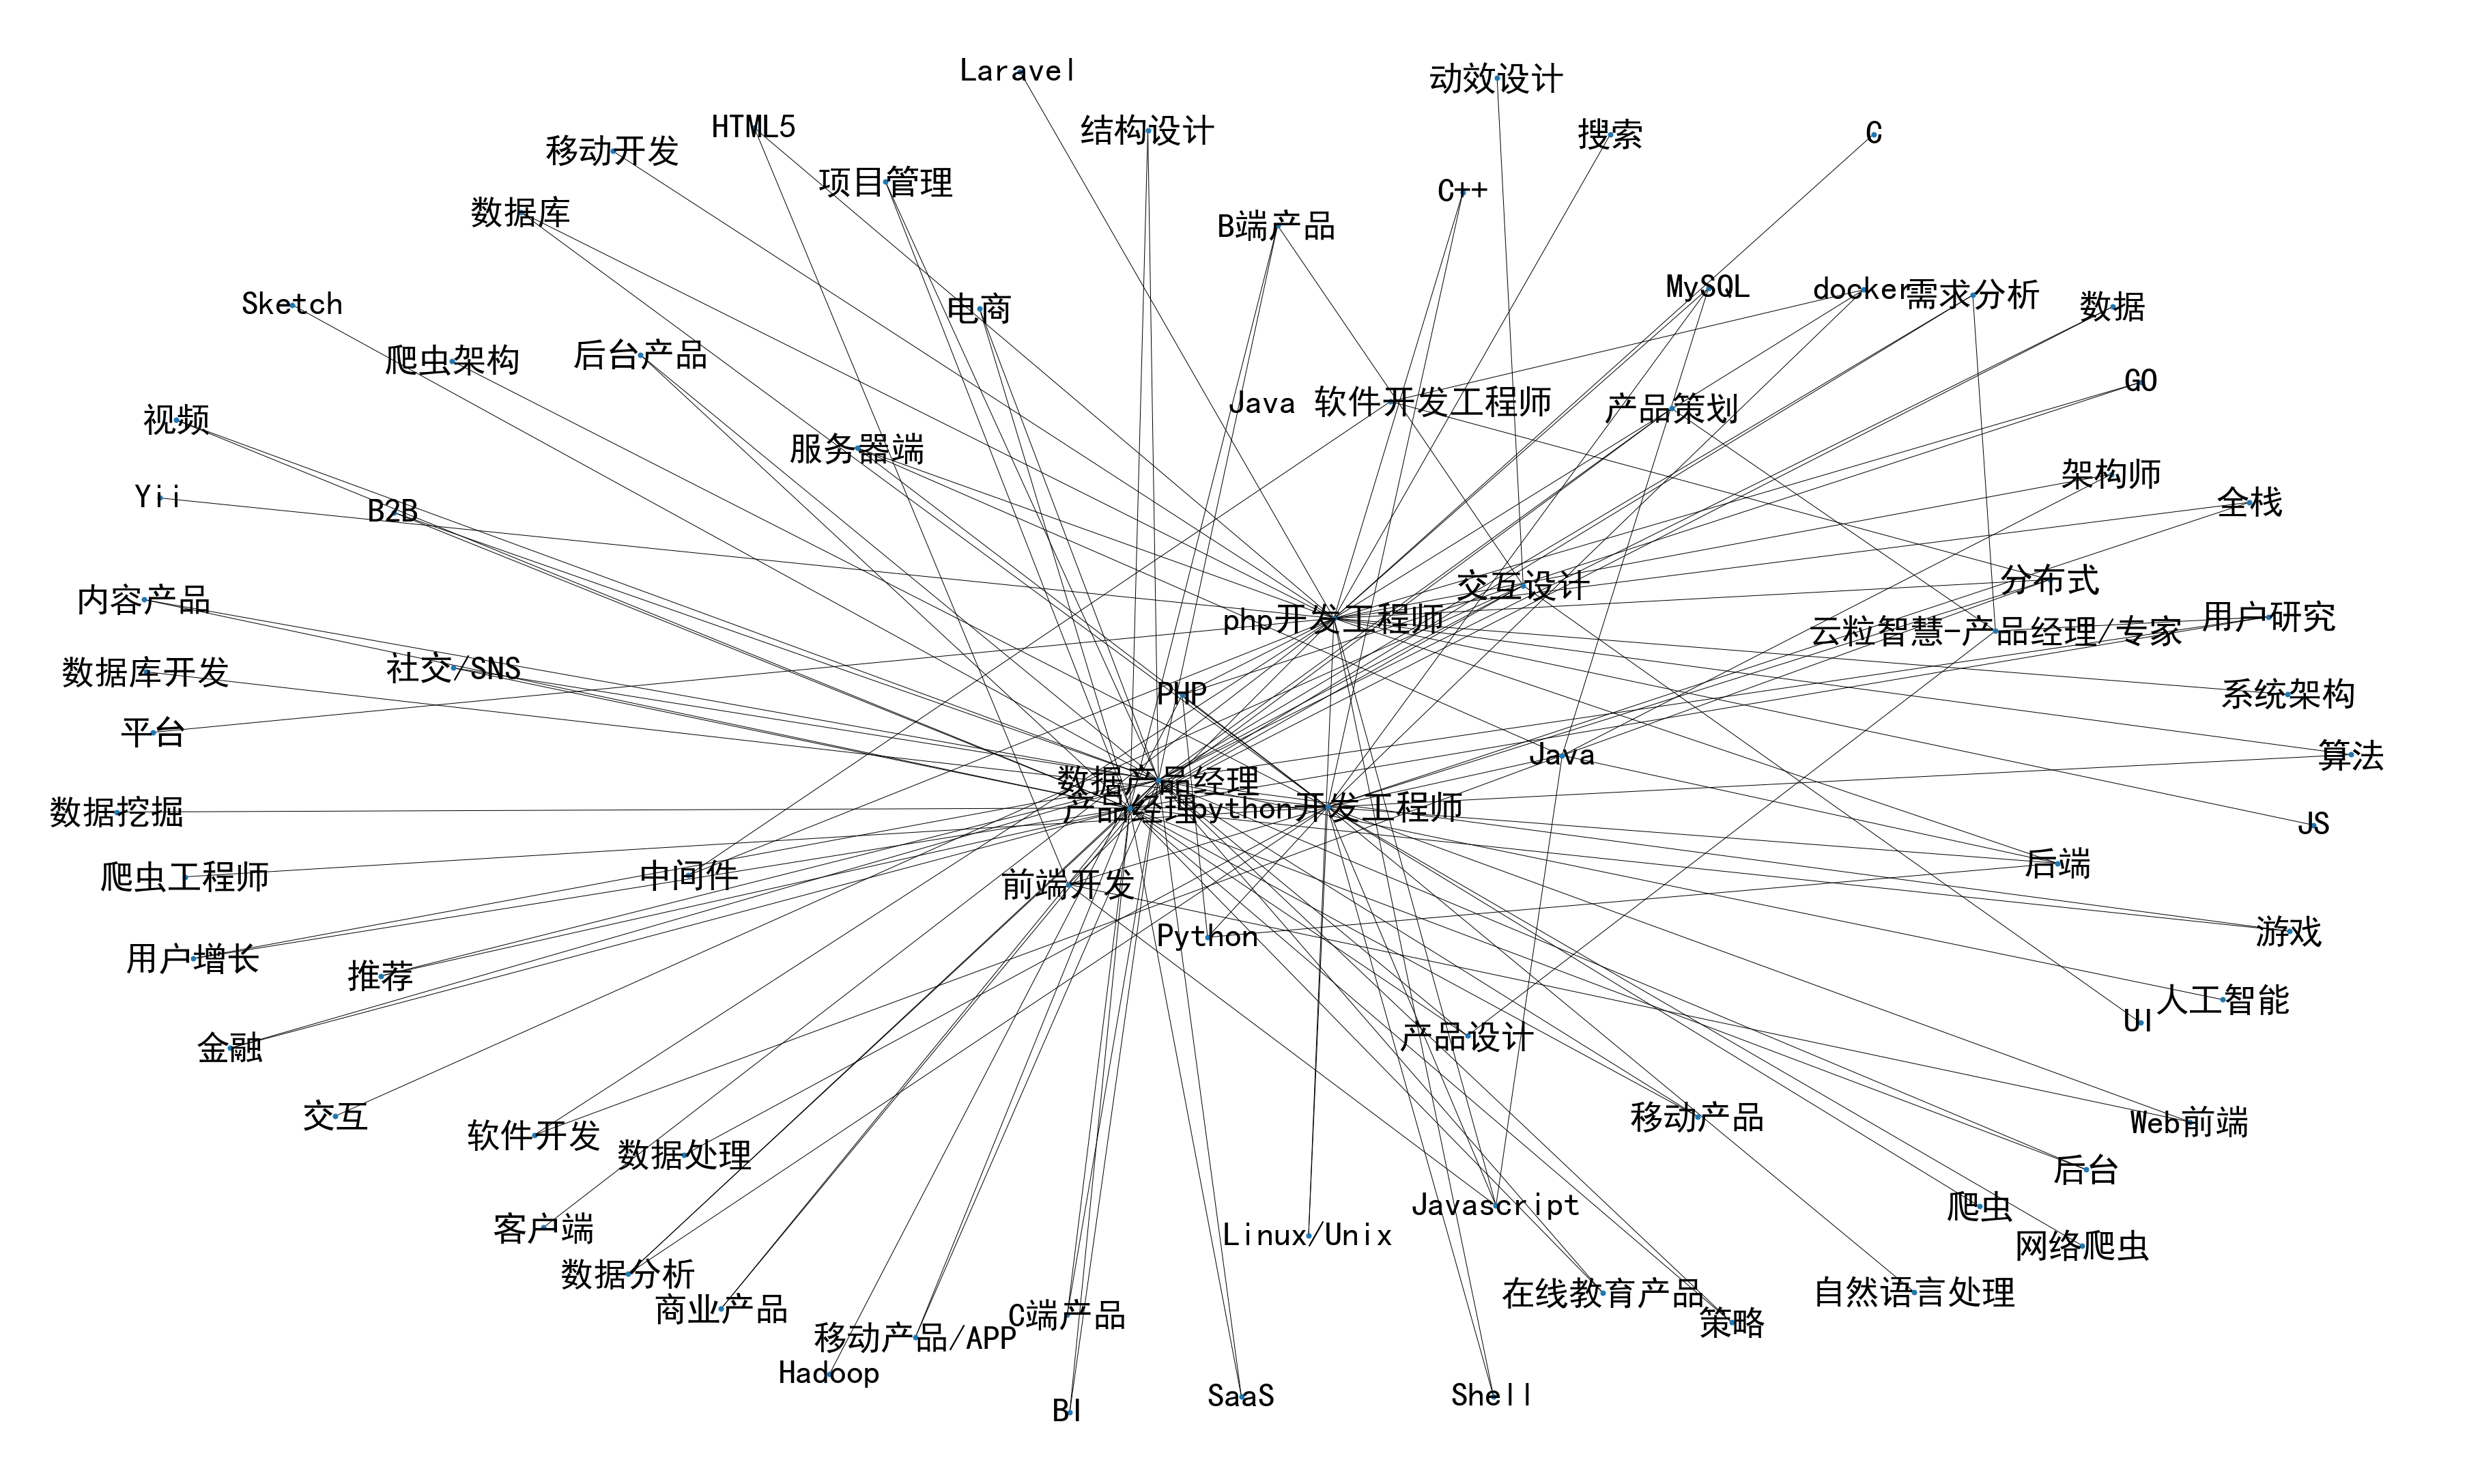

In [134]:
# 抽取G中的子图
sample_graph = G.subgraph(sample_nodes_connections)
plt.figure(figsize=(50,30))
pos = nx.spring_layout(sample_graph, k=1)
nx.draw(sample_graph, pos, with_labels=True, node_size=50,font_size=50)
plt.show()

In [135]:
len(sample_graph.edges) # 5个点生成172个关系边

144

### 5个职位共932个相关技能，生成172个关系边

In [136]:
# 使用pagerank算法，对核心能力和核心职位进行影响力的排序
pr = nx.pagerank(G, alpha=0.9) # alpha是阻尼因子，代表多少概率采用经典模型，剩下部分是随机浏览模型。如果不用，就可能出现等级泄露和等级沉默

1. 等级泄露（Rank Leak）：如果一个网页没有出链，就像是一个黑洞一样，吸收了其他网页的影响力而不释放，最终会导致其他网页的 PR 值为 0。可以按照上面的计算公式，初始设置为1/4，经过一次更新后就变为了原来的一半，而C一直没有贡献，所以对应的那一列为0，多次迭代后也会导致其它页面为0 。

2. 等级沉没（Rank Sink）：如果一个网页只有出链，没有入链（如下图所示），计算的过程迭代下来，会导致这个网页的 PR 值为 0（也就是不存在公式中的 V）。这种情况看上去感觉影响小一点，只是自己页面最后变为0。

In [137]:
# pr值
list(pr.items())[:10]

[('财务产品经理', 0.00039716221434541577),
 ('产品专家', 0.0007411296728644823),
 ('产品总监', 0.003940470794231084),
 ('联盟广告产品运营专家/专员-【商业化】', 0.00031652097844473917),
 ('资深产品经理（产品专家）', 0.000374926989825263),
 ('智能交通信息安全高级产品经理/产品总监/行业专家', 6.204243702692642e-05),
 ('高级产品经理', 0.0032195698117732452),
 ('产品经理/总监（视觉芯片半导体', 6.204243702692642e-05),
 ('产品经理', 0.012867362096047103),
 ('产品经理（客户端产品策划）（北京）', 0.00027544710201543707)]

In [138]:
ranked_position_and_ability = sorted( [(name, value) for name,value in pr.items()],key=lambda x:x[1],reverse=True)
ranked_position_and_ability[:10]

[('后端', 0.026833573370768898),
 ('运维', 0.0191279829833669),
 ('Python', 0.01716937562136133),
 ('PHP', 0.015217301132452196),
 ('Java', 0.015099988114363864),
 ('UI', 0.013501957339680843),
 ('产品经理', 0.012867362096047103),
 ('测试', 0.012366790452249686),
 ('交互', 0.009849405953488204),
 ('MySQL', 0.00967223844507533)]

In [139]:
# 特征X需要去掉salary字段
X_content = content.drop(['salary'],axis=1)
# label
target = content['salary'].tolist()

In [140]:
# 将X_content内容都拼接为字符串，设置为merged字段
X_content['merged'] = X_content.apply(lambda x:''.join(str(x)),axis=1) 
X_content['merged']

0       id                                            ...
1       id                                            ...
2       id                                            ...
3       id                                            ...
4       id                                            ...
                              ...                        
4506    id                                            ...
4507    id                                            ...
4508    id                                            ...
4509    id                                            ...
4510    id                                            ...
Name: merged, Length: 4511, dtype: object

In [141]:
X_string = X_content['merged'].tolist()
X_string[0]

"id                                                                   3\npositionName                                                    财务产品经理\ndistrict                                                           海淀区\nstationname                                                         上地\njobNature                                                           全职\ncompanyLabelList                      ['节日礼物', '年底双薪', '定期体检', '七险一金']\nindustryField                                               物流丨运输,软件开发\ncompanySize                                                  500-2000人\nskillLables                                      ['产品设计', '后台', 'B2B']\ncreateTime                                         2020-05-15 15:10:02\ncompanyFullName                                         北京福佑多多信息技术有限公司\nworkYear                                                          1-3年\neducation                                                           本科\npositionAdvantage                                     福利待遇好、创业黑

In [142]:
X_string[0].split('\n')

['id                                                                   3',
 'positionName                                                    财务产品经理',
 'district                                                           海淀区',
 'stationname                                                         上地',
 'jobNature                                                           全职',
 "companyLabelList                      ['节日礼物', '年底双薪', '定期体检', '七险一金']",
 'industryField                                               物流丨运输,软件开发',
 'companySize                                                  500-2000人',
 "skillLables                                      ['产品设计', '后台', 'B2B']",
 'createTime                                         2020-05-15 15:10:02',
 'companyFullName                                         北京福佑多多信息技术有限公司',
 'workYear                                                          1-3年',
 'education                                                           本科',
 'positionAdvantage      

In [143]:
'workYear                                                          1-3年'.split()

['workYear', '1-3年']


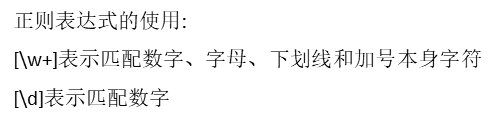

In [144]:
import jieba
import re

# 合并到一起
def get_one_row_job_string(x_string_row):
    job_string = ''
    for i,element in enumerate(x_string_row.split('\n')):
        if len(element.split()) == 2:
            _,value = element.split()
            # 去掉i==0的id字段
            if i == 0:
                continue
            # 只保留value
            job_string += value
    return job_string

def token(string):
    return re.findall('\w',string)

In [145]:
cutted_X = []
for i, row in enumerate(X_string):
    job_string = get_one_row_job_string(row)
    cutted_X.append(' '.join(list(jieba.cut(''.join(token(job_string))))))
cutted_X[:10]

['财务 产品 经理 海淀区 上 地 全职 物流 丨 运输 软件开发 5002000 人 北京 福佑 多多 信息技术 有限公司 13 年 本科 福利待遇 好 创业 黑马 技术 氛围 好 httpswwwlagoucomjobs7149613html 岗位职责 1 负责 财务 相关 业务 解决方案 架构 并 主导 与 产品 技术 等 交付 团队 的 对接 能够 从 完整 的 财务 产品线',
 '产品 专家 海淀区 中关村 全职 企业 服务 5002000 人 北京 拉勾 网络 技术 有限公司 510 年 本科 做好 产品 给 用户 用 httpswwwlagoucomjobs7056930html 负责 具体 产品线 的 工作 完成 用户 价值 解决 具体 产品线 的 问题 产品线 有 策略 运营 基础 产品 流程 等线 产品线',
 '产品 总监 海淀区 中关村 全职 企业 服务 5002000 人 北京 拉勾 网络 技术 有限公司 510 年 本科 做好 产品 给 用户 用 httpswwwlagoucomjobs6982266html 做出 好 产品 服务 用户 实现 用户 价值 B 端 产品 C 端 产品 商业 策略 产品 运营 产品 等 岗位 都 有 总 产品线',
 '联盟 广告 产品 运营 专家 专员 商业化 海淀区 东单 全职 文娱 丨 内容 2000 人 以上 产品 运营 北京 达佳 互联 信息技术 有限公司 510 年 不限 httpswwwlagoucomjobs7112346html 产品线',
 '产品 总监 海淀区 中关村 全职 移动 互联网 社交 1550 人 北京 领主 科技 有限公司 510 年 本科 发展 创新 httpswwwlagoucomjobs6864122html 产品线',
 '产品 总监 海淀区 中关村 全职 教育 5002000 人 北京 励立 长平 教育 科技 有限公司 510 年 本科 六险 一金 节假日 福利 生日礼品 等 httpswwwlagoucomjobs7038327html 技能 要求 B 端 产品 C 端 产品 在线教育 产品 一 岗位职责 1 负责 公司 产品 发展 方向 的 整体 把握 和 产品线',
 '产品 总监 海淀区 知春路 全职 电商 150500 人 北京 开心 代代 科技 有限

## Step3，提取文本特征 TFIDF

In [146]:
# 使用TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cutted_X)
X

<4511x9397 sparse matrix of type '<class 'numpy.float64'>'
	with 128866 stored elements in Compressed Sparse Row format>

In [147]:
print(X,X.shape,len(cutted_X))

  (0, 4867)	0.08067382643510919
  (0, 6292)	0.20009145587805918
  (0, 8425)	0.1579560119122034
  (0, 6368)	0.17665301724378638
  (0, 5947)	0.08919099991949327
  (0, 4844)	0.18098871672173852
  (0, 4704)	0.17377734982977522
  (0, 7427)	0.12806870213260702
  (0, 8664)	0.16653746915733844
  (0, 4620)	0.0924431318382734
  (0, 7958)	0.10579206223251938
  (0, 8777)	0.0627793041108492
  (0, 6450)	0.0694001752771764
  (0, 4014)	0.2547712257295339
  (0, 7538)	0.10080943358604699
  (0, 6850)	0.07710967023957215
  (0, 9381)	0.2345227567545943
  (0, 5455)	0.17377734982977522
  (0, 8031)	0.12174170827441123
  (0, 7378)	0.032958160533437766
  (0, 30)	0.07814772806027713
  (0, 7334)	0.0310424928669057
  (0, 5205)	0.09312782800519334
  (0, 6075)	0.17767811771366668
  (0, 8028)	0.2280042057131061
  :	:
  (4509, 101)	0.07157693343910868
  (4509, 6450)	0.0664206301112013
  (4509, 7378)	0.03154317379162286
  (4509, 7334)	0.02970975113834377
  (4509, 5556)	0.035993007833540154
  (4509, 5312)	0.028616509438

## tfidf对每一个cut生成一个长度为9397的向量，共4511个向量
## (4509, 101)	0.07157693343910868 表示第4509行向量的第101个位置为0.0715..

In [148]:
import numpy as np
target_numical = [np.mean(list(map(float, re.findall('\d+', s) ))) for s in target]
target_numical[:10]

[12.5, 40.0, 57.5, 30.0, 29.0, 40.0, 50.0, 40.0, 55.0, 40.0]

In [149]:
list(map(float,re.findall('\d+', target[0])))

[10.0, 15.0]

In [150]:
Y = target_numical

In [157]:
print(X)

  (0, 4867)	0.08067382643510919
  (0, 6292)	0.20009145587805918
  (0, 8425)	0.1579560119122034
  (0, 6368)	0.17665301724378638
  (0, 5947)	0.08919099991949327
  (0, 4844)	0.18098871672173852
  (0, 4704)	0.17377734982977522
  (0, 7427)	0.12806870213260702
  (0, 8664)	0.16653746915733844
  (0, 4620)	0.0924431318382734
  (0, 7958)	0.10579206223251938
  (0, 8777)	0.0627793041108492
  (0, 6450)	0.0694001752771764
  (0, 4014)	0.2547712257295339
  (0, 7538)	0.10080943358604699
  (0, 6850)	0.07710967023957215
  (0, 9381)	0.2345227567545943
  (0, 5455)	0.17377734982977522
  (0, 8031)	0.12174170827441123
  (0, 7378)	0.032958160533437766
  (0, 30)	0.07814772806027713
  (0, 7334)	0.0310424928669057
  (0, 5205)	0.09312782800519334
  (0, 6075)	0.17767811771366668
  (0, 8028)	0.2280042057131061
  :	:
  (4509, 101)	0.07157693343910868
  (4509, 6450)	0.0664206301112013
  (4509, 7378)	0.03154317379162286
  (4509, 7334)	0.02970975113834377
  (4509, 5556)	0.035993007833540154
  (4509, 5312)	0.028616509438

In [165]:
print(X[0])

  (0, 4867)	0.08067382643510919
  (0, 6292)	0.20009145587805918
  (0, 8425)	0.1579560119122034
  (0, 6368)	0.17665301724378638
  (0, 5947)	0.08919099991949327
  (0, 4844)	0.18098871672173852
  (0, 4704)	0.17377734982977522
  (0, 7427)	0.12806870213260702
  (0, 8664)	0.16653746915733844
  (0, 4620)	0.0924431318382734
  (0, 7958)	0.10579206223251938
  (0, 8777)	0.0627793041108492
  (0, 6450)	0.0694001752771764
  (0, 4014)	0.2547712257295339
  (0, 7538)	0.10080943358604699
  (0, 6850)	0.07710967023957215
  (0, 9381)	0.2345227567545943
  (0, 5455)	0.17377734982977522
  (0, 8031)	0.12174170827441123
  (0, 7378)	0.032958160533437766
  (0, 30)	0.07814772806027713
  (0, 7334)	0.0310424928669057
  (0, 5205)	0.09312782800519334
  (0, 6075)	0.17767811771366668
  (0, 8028)	0.2280042057131061
  (0, 5556)	0.03760760848276288
  (0, 99)	0.08029930379522264
  (0, 8899)	0.12621920066825987
  (0, 8960)	0.19058509768494367
  (0, 7785)	0.18098871672173852
  (0, 5312)	0.029900209731763727
  (0, 7640)	0.0516

## Step4，回归分析，使用KNN回归，朴素贝叶斯回归，训练能力和薪资匹配模型

In [166]:
# 使用KNN模型
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=2)
model_knn.fit(X, Y)

from sklearn import linear_model
model_b = linear_model.BayesianRidge()
model_b.fit(X.toarray(), Y)

KNeighborsRegressor(n_neighbors=2)

In [175]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X, Y)

LGBMRegressor()

In [118]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

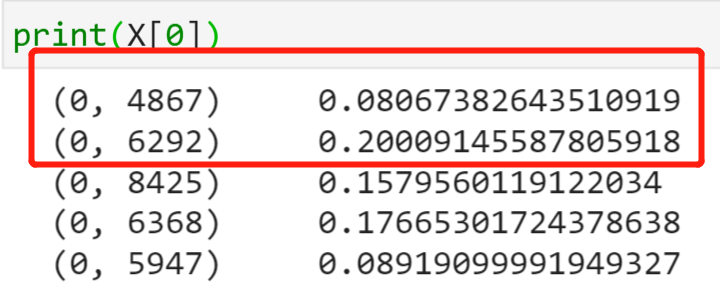

In [119]:
X.toarray()[0][4867],X.toarray()[0][6292]

(0.08067382643510919, 0.20009145587805918)

In [167]:
def predict_by_label(test_sting, model):
    test_words = list(jieba.cut(test_sting))
    test_vec = vectorizer.transform(test_words)
    y_pred = model.predict(test_vec)
    return y_pred[0]
test = '北京算法硕士3年掌握图像识别'
predict_by_label(test,model_knn)

28.75

In [168]:
test_words = list(jieba.cut(test))
test_vec = vectorizer.transform(test_words)
y_pred = model_knn.predict(test_vec)
y_pred

array([28.75, 19.25, 38.75, 30.  , 30.  , 15.25, 30.  ])

In [174]:
test_vec.toarray().shape

(7, 9397)

In [173]:
print(test_vec,'\n',test_vec.shape)

  (0, 5556)	1.0
  (1, 8140)	1.0
  (2, 8008)	1.0
  (5, 6942)	1.0 
 (7, 9397)


## Step5，基于指定的能力关键词，预测薪资

In [87]:
# 
persons=["广州Java本科3年掌握大数据",
"沈阳Java硕士3年掌握大数据", 
"沈阳Java本科3年掌握大数据", 
"北京算法硕士3年掌握图像识别"]
for p in persons:
    print(f'{p}的薪资预测为{predict_by_label(p,model_knn)}')

广州Java本科3年掌握大数据的薪资预测为20.0
沈阳Java硕士3年掌握大数据的薪资预测为30.0
沈阳Java本科3年掌握大数据的薪资预测为30.0
北京算法硕士3年掌握图像识别的薪资预测为28.75


In [109]:
# 贝叶斯回归
persons=["广州Java本科3年掌握大数据",
"沈阳Java硕士3年掌握大数据", 
"沈阳Java本科3年掌握大数据", 
"北京算法硕士3年掌握图像识别"]
for p in persons:
    print(f'{p}的薪资预测为{predict_by_label(p,model_b)}')

广州Java本科3年掌握大数据的薪资预测为25.844434144491505
沈阳Java硕士3年掌握大数据的薪资预测为21.51800464187595
沈阳Java本科3年掌握大数据的薪资预测为21.51800464187595
北京算法硕士3年掌握图像识别的薪资预测为32.093697318526225


In [178]:
# lgb
persons=["广州Java本科3年掌握大数据",
"沈阳Java硕士3年掌握大数据", 
"沈阳Java本科3年掌握大数据", 
"北京算法硕士3年掌握图像识别"]
for p in persons:
    print(f'{p}的薪资预测为{predict_by_label(p,model_lgb)}')

广州Java本科3年掌握大数据的薪资预测为11.32146616134228
沈阳Java硕士3年掌握大数据的薪资预测为11.099393042219829
沈阳Java本科3年掌握大数据的薪资预测为11.099393042219829
北京算法硕士3年掌握图像识别的薪资预测为11.954146604029516
